# Be/Bi 205 Course Project -- Data exploration

### From Therapeutics Data Commons, I've chosen to work on Gene-Disease association prediction task for this project. 
https://tdcommons.ai/multi_pred_tasks/gdi/

The task uses data from DisGeNet (https://www.disgenet.org/) -- the largest publicly available collection of genes and variants associated with human diseases curated from various catalogues, annotated with controlled vocabularies

TDC has curated a subset of data from DisGeNet and mapped disease ID to definition through MedGen (https://www.ncbi.nlm.nih.gov/medgen/), and Gene ID to uniprot (https://www.uniprot.org/) amino acid sequence. The task is to quantify the association between gene and disease given the disease description and gene amino acid sequence through regression.

Dataset statistics on TDC: 52476 gene-disease pairs, 7399 genes, 7095 diseases 

### Rationale behind the task (as I understand it)

Many diseases are caused by genetic variations, and for a given disease, its clinical presentation (phenotype) may vary among patients either due to reduced penetrance or variable expressivity or a combination of both, which makes the task of identifying therapeutic target genes difficult. Studies analyzing a disease try to identify genomic regions associated with the disease and then verify the function of genes in that region, ranking candidate genes for analysis following a "guilt-by-association" principle, i.e. associated genes would share common functionality and show common traits across different genomic data. But this is only useful to find candidate genes for diseases that already have a partial genetic basis identified.

However, the guilt-by-association principle can be extended to phenotypically related diseases, i.e. genes associated with phenotypically related diseases could also share common traits and functionality. Thus, a GDA network is constructed to probe gene-disease mechanisms for pairs of multiple genes and diseases. Deep learning can be used to fill the gaps in GDA network by training on known gene-disease associations and then extrapolating to unknown pairs to identify candidate targets.

### TDC data

In [1]:
from tdc.multi_pred import GDA
data = GDA(name = 'DisGeNET')
split = data.get_split()

Found local copy...
Loading...
Done!


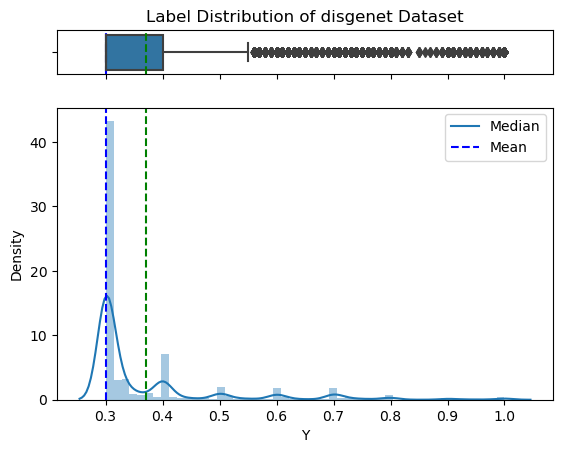

In [2]:
data.label_distribution()

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [4]:
traindf = pd.DataFrame(split['train'])
valdf = pd.DataFrame(split['valid'])
testdf = pd.DataFrame(split['test'])
print('Training samples: ',len(traindf))
print('Validation samples: ',len(valdf))
print('Testing samples: ',len(testdf))

Training samples:  36733
Validation samples:  5248
Testing samples:  10495


In [5]:
traindf.head()

Gene_ID                                               Gene Disease_ID  \
0        1  MSMLVVFLLLWGVTWGPVTEAAIFYETQPSLWAESESLLKPLANVT...   C0019209   
1        1  MSMLVVFLLLWGVTWGPVTEAAIFYETQPSLWAESESLLKPLANVT...   C0036341   
2        2  MGKNKLLHPSLVLLLLVLLPTDASVSGKPQYMVLVPSLLHTETTEK...   C0002395   
3        2  MGKNKLLHPSLVLLLLVLLPTDASVSGKPQYMVLVPSLLHTETTEK...   C0011265   
4        2  MGKNKLLHPSLVLLLLVLLPTDASVSGKPQYMVLVPSLLHTETTEK...   C0019202   

                                             Disease    Y  
0   Hepatomegaly: Abnormal enlargement of the liver.  0.3  
1  Schizophrenia: Schizophrenia is highly heritab...  0.3  
2  Alzheimer's Disease: Alzheimer disease is the ...  0.5  
3  Presenile dementia: The presence of dementia i...  0.3  
4  Hepatolenticular Degeneration: Wilson disease ...  0.3

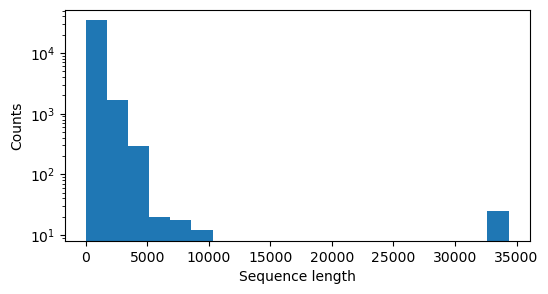

In [6]:
## Length of amino acid sequences
genelengths = [len(g) for g in traindf['Gene']]
plt.figure(figsize=(6,3))
_ = plt.hist(genelengths,bins=20,log=True)
plt.ylabel('Counts')
plt.xlabel('Sequence length')
plt.show()
## Not uniform

In [7]:
## Amino acid sequence alphabet
alphabets = np.unique([item for g in traindf['Gene'] for item in list(set(g))])
alphabets

array(['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P',
       'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y'], dtype='<U1')

In [8]:
global alphabet_map
alphabet_map = {'A':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6, 'H':7, 'I':8, 'K':9, 'L':10, 'M':11, 'N':12, 'P':13,
       'Q':14, 'R':15, 'S':16, 'T':17, 'U':18, 'V':19, 'W':20, 'X':21, 'Y':22}

In [40]:
## Example disease description
traindf['Disease'][0]

'Hepatomegaly: Abnormal enlargement of the liver.'

### Data preprocessing
- Gene column would need to be converted to one-hot encoded arrays, and padded to make their lengths uniform
- Disease column would need to be converted to a uniform vector embedding using some NLP method

In [31]:
import tensorflow as tf
import spacy
import en_core_web_md
from gensim.corpora.dictionary import Dictionary
from gensim.models.word2vec import Word2Vec
import gensim.downloader as api

2023-04-28 15:05:08.528867: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error


- First dealing with sequences

In [19]:
def convert_to_onehot(seq):
    ohe = np.zeros((len(seq),len(alphabet_map)+1))
    for i,s in enumerate(seq):
        ohe[i,alphabet_map[s]] = 1
    return ohe[:,1:]

In [20]:
%%time 
X = [convert_to_onehot(g) for g in traindf['Gene']]

CPU times: user 3.5 s, sys: 816 ms, total: 4.32 s
Wall time: 4.32 s


In [28]:
traindf['X1'] = X

Since shape of X1 is not uniform (each sample is sequence_length x alphabet_length and sequence length varies),
it will be padded before training

- Next dealing with disease descriptions

Looking at two approaches here, first to get word embeddings and use averaged word vectors to get sentence vector

In [37]:
%%time
## Tokenize our disease descriptions 
nlp = en_core_web_md.load()
tokens = []
removal= ['ADV','PRON','CCONJ','PUNCT','PART','DET','ADP','SPACE', 'SYM']
for disease in nlp.pipe(traindf['Disease']):
    tokens.append([token.lemma_ for token in disease if token.pos_ not in removal])

CPU times: user 3min 39s, sys: 378 ms, total: 3min 39s
Wall time: 3min 40s


In [38]:
traindf['tokens'] = tokens

In [39]:
tokens[0]

['hepatomegaly', 'abnormal', 'enlargement', 'liver']

In [64]:
## Train gensim Word2vec model, it takes list of str tokens directly
model = Word2Vec(traindf['tokens'])

In [73]:
model.wv.most_similar("hepatomegaly")

[('lymphadenopathy', 0.6800524592399597),
 ('splenomegaly', 0.6631979942321777),
 ('hepatosplenomegaly', 0.6514338254928589),
 ('transaminase', 0.6323346495628357),
 ('iron', 0.6228795051574707),
 ('jaundice', 0.609259843826294),
 ('hypermetabolism', 0.5977323055267334),
 ('hyperlipidemia', 0.5799980163574219),
 ('storage', 0.5683786273002625),
 ('dehydration', 0.5414830446243286)]

In [82]:
sentvecs = []
for sent in traindf['tokens']:
    sentvecs.append(np.mean([model.wv.word_vec(word) for word in sent if model.wv.has_index_for(word)],axis=0))

In [84]:
np.shape(sentvecs)

(36733, 100)

In [85]:
traindf['X2_1'] = sentvecs

In [101]:
traindf['X2_1'][0]

array([-0.52782047, -0.04894644,  0.76871836, -1.0649453 , -1.5059873 ,
       -0.6001269 ,  0.54573756, -0.45159644,  1.2727453 , -0.12144589,
        0.62991273,  1.5930324 , -1.5477872 , -0.7542422 ,  0.8003924 ,
        0.99251795, -0.72856915, -0.6127136 ,  0.7354403 ,  1.5507761 ,
        0.8774863 ,  0.06242841,  1.0365998 , -0.16637748, -0.08315891,
       -0.40897864,  0.54345566, -0.31396005, -0.22021526,  0.09733475,
       -0.6424665 , -0.86649257,  0.5254741 , -0.79103935,  1.3729737 ,
        0.44039637,  1.1916041 ,  0.13361013, -0.56389415,  1.0949733 ,
        1.0677724 ,  2.1772964 ,  0.42967787, -1.1127867 , -0.38290417,
       -0.7928448 , -0.15492609,  1.2799029 ,  0.7262238 ,  0.22973257,
       -0.7824364 , -1.1150577 , -1.2449121 ,  0.12956107, -0.63287103,
        0.66198504,  0.03185637,  0.17376429, -0.37552828, -0.5302457 ,
       -0.21630587,  1.3483291 , -0.9437089 ,  0.81244427,  0.615585  ,
        1.2106735 ,  0.43051308, -0.8922671 , -1.37398   ,  0.68

Second approach - doc2vec embeddings

In [86]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [96]:
dictionary = Dictionary(traindf['tokens'])
documents = [TaggedDocument(doc,dictionary.doc2idx(doc)) for doc in traindf['tokens']]

In [98]:
model = Doc2Vec(documents,vector_size=20)

In [99]:
traindf['X2_2'] = [model.infer_vector(doc) for doc in traindf['tokens']]

In [100]:
traindf['X2_2'][0]

array([ 0.14122088, -0.06563216, -0.00734649, -0.2059837 ,  0.08993583,
        0.04964326, -0.03235229, -0.27719197, -0.20296392, -0.03021958,
       -0.06755918,  0.12062613,  0.07048996,  0.17293632,  0.00637513,
       -0.17755455, -0.00840605, -0.12333015, -0.02660876, -0.06621847],
      dtype=float32)

Visualize embeddings

In [102]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [103]:
tsne = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)

In [107]:
tvals = tsne.fit_transform(list(traindf['X2_1']))

In [108]:
traindf['tsne_x'] = tvals[:,0]
traindf['tsne_y'] = tvals[:,1]

In [2]:
# %matplotlib inline
# import plotly.express as px
# px.scatter(traindf,x='tsne_x',y='tsne_y',color='Disease_ID')

In [112]:
tsne2 = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
tvals2 = tsne2.fit_transform(list(traindf['X2_2']))

In [115]:
traindf['tsne_x2'] = tvals2[:,0]
traindf['tsne_y2'] = tvals2[:,1]

In [116]:
px.scatter(traindf,x='tsne_x2',y='tsne_y2',color='Disease_ID')

Doc2Vec embedding looks better